In [1]:

from GridWorldOption import GridWorldOption
from GridWorld import GridWorld
from mcts.MCTS import MCTS
from numpy.random import choice

import numpy as np

In [2]:
from GridWorld import GridWorld
from GridWorldOption import GridWorldOption
from mcts.MCTS import MCTS

from numpy.random import choice
import numpy as np

import ray
import matplotlib.pyplot as plt

SIM_RANGE = list(range(20, 100, 5))
SMOOTH = 10

MAP_NAME = './maps/door.map'
with open(MAP_NAME) as f:
    env_map = f.read()

@ray.remote
def run_single_sim(sims, smooth):
    print('only prims', sims, smooth)

    options = [
      # primitives, (0,0) is meaningless
      GridWorldOption((0, 0),  {'all'}, 0, 0),
      GridWorldOption((0, 0),  {'all'}, 1, 1),
      GridWorldOption((0, 0),  {'all'}, 2, 2),
      GridWorldOption((0, 0),  {'all'}, 3, 3),
    ]

    env = GridWorld(env_map, 10000)
    done = False
    R = 0.0
    while not done:
        mcts = MCTS(env.copy(), options)
        pi = mcts.run_sim(sims)
        #opt = choice(options, 1, p=pi)[0]
        opt_index = np.argmax(pi)
        opt = options[opt_index]
        while True:
            a, should_break = opt.get_action(env)

            if a == -1 or done:
                break
            
            _, r, done = env.step(a)

            R += r

            if should_break:
                break

    return R
@ray.remote
def run_smoothed(sims, smooth_factor):
    features = [run_single_sim.remote(sims, smooth) for smooth in range(smooth_factor)]
    totals = ray.get(features)
    print(totals)
    return sum(totals)/len(totals)


@ray.remote
def run_single_sim_options(sims, smooth):
    print('random opts', sims, smooth)

    env = GridWorld(env_map, 10000)

    options = [
      # primitives, (0,0) is meaningless
      GridWorldOption((0, 0),   {'all'}, 0, 0),
      GridWorldOption((0, 0),   {'all'}, 1, 1),
      GridWorldOption((0, 0),   {'all'}, 2, 2),
      GridWorldOption((0, 0),   {'all'}, 3, 3),
      GridWorldOption((2, 11),  {'all'}, 4),
      GridWorldOption((9, 4),   {'all'}, 5),
    ]

    env = GridWorld(env_map)
    done = False
    R = 0.0
    while not done:
        mcts = MCTS(env.copy(), options)
        pi = mcts.run_sim(sims)
        #opt = choice(options, 1, p=pi)[0]
        opt_index = np.argmax(pi)
        opt = options[opt_index]
        while True:
            a, should_break = opt.get_action(env)

            if a == -1 or done:
                break
            
            _, r, done = env.step(a)

            R += r

            if should_break:
                break

    return R
    
@ray.remote
def run_smoothed_options(sims, smooth_factor):
    features = [run_single_sim_options.remote(sims, smooth) for smooth in range(smooth_factor)]
    totals = ray.get(features)
    print(totals)
    return sum(totals)/len(totals)



@ray.remote
def run_single_sim_doors(sims, smooth):
    print('door opts', sims, smooth)

    first_room_pos = [(i,j) for i in range(6) for j in range(8)]
    second_room_pos = [(i,j) for i in range(6) for j in range(9, 15)]
    third_room_pos = [(i,j) for i in range(7,13) for j in range(8)]
    fourth_room_pos = [(i,j) for i in range(7,13) for j in range(9,15)]

    options = [
      # primitives, (0,0) is meaningless
      GridWorldOption((0, 0),   {'all'}, 0, 0),
      GridWorldOption((0, 0),   {'all'}, 1, 1),
      GridWorldOption((0, 0),   {'all'}, 2, 2),
      GridWorldOption((0, 0),   {'all'}, 3, 3),
      GridWorldOption((3,8),  set(first_room_pos + second_room_pos + [(6,3)] + [(6,13)]), 4),
      GridWorldOption((6,3),  set(first_room_pos + third_room_pos + [(3,8)] + [(11,8)]), 5),
      GridWorldOption((6,13), set(second_room_pos + fourth_room_pos + [(3,8)] + [(11,8)]), 6),
      GridWorldOption((11,8), set(third_room_pos + fourth_room_pos + [(6,3)] + [(6,13)]), 7),
    ]

    env = GridWorld(env_map, 10000)
    done = False
    R = 0.0
    while not done:
        mcts = MCTS(env.copy(), options)
        pi = mcts.run_sim(sims)
        #opt = choice(options, 1, p=pi)[0]
        opt_index = np.argmax(pi)
        opt = options[opt_index]
        while True:
            a, should_break = opt.get_action(env)

            if a == -1 or done:
                break
            
            _, r, done = env.step(a)

            R += r

            if should_break:
                break

    return R

@ray.remote
def run_smoothed_doors(sims, smooth_factor):
    features = [run_single_sim_doors.remote(sims, smooth) for smooth in range(smooth_factor)]
    totals = ray.get(features)
    print(totals)
    return sum(totals)/len(totals)


features = [run_smoothed.remote(sims, SMOOTH) for sims in SIM_RANGE]
out = ray.get(features)

features = [run_smoothed_options.remote(sims, SMOOTH) for sims in SIM_RANGE]
out2 = ray.get(features)

features = [run_smoothed_doors.remote(sims, SMOOTH) for sims in SIM_RANGE]
out3 = ray.get(features)


print('RESULT 1', out)
print('RESULT 2', out2)
print('RESULT 3', out3)

# plt.title('MCTS-O: Planning with Options, Acting with options following Argmax')

# plt.ylabel('Average Total Undiscounted Return')
# plt.xlabel('MCTS Simulations')

# plt.plot(SIM_RANGE, out, label='primitive options')
# plt.plot(SIM_RANGE, out2, label='random options')
# plt.plot(SIM_RANGE, out3, label='dooor options')

# plt.hlines(-24, SIM_RANGE[0], SIM_RANGE[-1], colors='red', label='optimal')

# mini = min([min(out), min(out2), min(out3)])
# plt.ylim((mini,0))

# plt.legend()
# #plt.show()

# plt.savefig('test.png')

2021-09-17 13:49:20,336	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=21775) only prims 20 2
(pid=21780) only prims 20 1
(pid=21771) only prims 20 0
(pid=21773) only prims 20 4
(pid=21778) only prims 20 3


2021-09-17 13:49:22,222	WARNING worker.py:1189 -- WARNING: 36 PYTHON workers have been started on a node of the id: 9ffc76315717622ebd61eb90aa9d2a71069e4da6bcb2b73777cdf23a and address: 192.168.0.19. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


(pid=22027) only prims 20 5
(pid=22047) only prims 25 0
(pid=22046) only prims 30 0
(pid=21962) only prims 40 0
(pid=22054) only prims 45 0
(pid=22050) only prims 35 0
(pid=22056) only prims 55 0
(pid=21778) only prims 50 0
(pid=22445) only prims 20 6
(pid=21773) only prims 25 1
(pid=21780) only prims 60 0
(pid=21771) only prims 40 1
(pid=22027) only prims 30 1
(pid=22054) only prims 45 1
(pid=22050) only prims 55 1
(pid=22445) only prims 35 1
(pid=22056) only prims 50 1
(pid=22046) only prims 65 0
(pid=22466) only prims 20 7
(pid=21771) only prims 25 2
(pid=22050) only prims 60 1
(pid=21962) only prims 40 2
(pid=21775) only prims 30 2
(pid=22056) only prims 45 2
(pid=22027) only prims 55 2
(pid=21773) only prims 35 2
(pid=21771) only prims 50 2
(pid=22529) only prims 70 0
(pid=21780) only prims 65 1
(pid=22054) only prims 25 3
(pid=22050) only prims 20 8
(pid=22466) only prims 60 2
(pid=21775) only prims 40 3
(pid=22056) only prims 30 3
(pid=21780) only prims 45 3
(pid=21773) only pri

(pid=23107) random opts 25 0
(pid=23414) random opts 35 1
(pid=23414) random opts 40 1
(pid=22897) random opts 50 1
(pid=22900) random opts 30 1
(pid=22904) random opts 45 1
(pid=22903) random opts 75 1
(pid=22897) random opts 55 1
(pid=22899) random opts 70 1
(pid=22895) random opts 65 1
(pid=22901) random opts 20 1
(pid=22905) random opts 60 1
(pid=22898) random opts 25 1
(pid=22901) random opts 80 0
(pid=23498) random opts 85 0
(pid=23498) random opts 35 2
(pid=22895) random opts 40 2
(pid=22904) random opts 50 2
(pid=23414) random opts 30 2
(pid=22901) random opts 45 2
(pid=22898) random opts 75 2
(pid=22900) random opts 55 2
(pid=22904) random opts 70 2
(pid=22905) random opts 65 2
(pid=22895) random opts 20 2
(pid=22897) random opts 60 2
(pid=22900) random opts 80 1
(pid=22904) random opts 25 2
(pid=23596) random opts 90 0
(pid=22900) random opts 85 1
(pid=22901) random opts 35 3
(pid=23498) random opts 40 3
(pid=22901) random opts 50 3
(pid=22904) random opts 45 3
(pid=22900) ra

(pid=24429) door opts 25 0
(pid=24410) door opts 35 1
(pid=24410) door opts 60 1
(pid=24429) door opts 65 1
(pid=24158) door opts 20 1
(pid=24158) door opts 70 1
(pid=24156) door opts 75 1
(pid=24152) door opts 50 1
(pid=24159) door opts 45 1
(pid=24155) door opts 30 1
(pid=24152) door opts 55 1
(pid=24156) door opts 40 1
(pid=24158) door opts 80 0
(pid=24152) door opts 25 1
(pid=24154) door opts 35 2
(pid=24662) door opts 85 0
(pid=24410) door opts 60 2
(pid=24150) door opts 65 2
(pid=24410) door opts 20 2
(pid=24154) door opts 75 2
(pid=24153) door opts 70 2
(pid=24152) door opts 50 2
(pid=24157) door opts 45 2
(pid=24410) door opts 30 2
(pid=24429) door opts 55 2
(pid=24153) door opts 40 2
(pid=24410) door opts 80 1
(pid=24159) door opts 25 2
(pid=24429) door opts 90 0
(pid=24158) door opts 35 3
(pid=24684) door opts 85 1
(pid=24153) door opts 60 3
(pid=24155) door opts 65 3
(pid=24410) door opts 20 3
(pid=24158) door opts 75 3
(pid=24151) door opts 70 3
(pid=24159) door opts 50 3
(

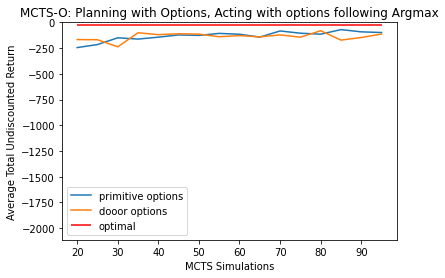

In [5]:
plt.title('MCTS-O: Planning with Options, Acting with options following Argmax')

plt.ylabel('Average Total Undiscounted Return')
plt.xlabel('MCTS Simulations')

plt.plot(SIM_RANGE, out, label='primitive options')
#plt.plot(SIM_RANGE, out2, label='random options')
plt.plot(SIM_RANGE, out3, label='dooor options')

plt.hlines(-24, SIM_RANGE[0], SIM_RANGE[-1], colors='red', label='optimal')

mini = min([min(out), min(out2), min(out3)])
plt.ylim((mini,0))

plt.legend()
#plt.show()
